# settings

In [1]:
import numpy as np
import copy
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import minimize
import GPy
import matplotlib.pyplot as plt
from scipy import special
import math
from scipy.stats import norm

In [2]:
def cov_RBF(x1, x2, parameters):  
    
    lengthscale_square =   parameters[:,0]  # lengthscale^2
    variance = parameters[:,1] # sigma^2


    if x1.shape[1]!=x2.shape[1]:
        x1=np.reshape(x1,(-1,x2.shape[1]))

    Euc_dist=euclidean_distances(x1,x2)

    return variance*np.exp(-0.5*np.square(Euc_dist)/lengthscale_square)




def log_llk(X,y,parameters):

    noise_delta = 10**(-6)
    
    parameters = parameters.reshape(-1,2)

    KK_x_x=cov_RBF(X,X,parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y.T,KK_inv),y)
            

    except: # singular
        return -np.inf

    logmarginal = first_term+second_term -0.5*len(y)*np.log(2*3.1415926)
    
    return logmarginal.item()


def optimise(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}

    bounds = np.array([[0.015**2,0.6**2],[0.01,10]])
    hyper_num = 2
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(50, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [3]:
def log_llk_warp(X,y,parameters):

    noise_delta = 10**(-6)
    
    parameters = parameters.reshape(-1,3)
    kernel_parameters = parameters[:,:2]
    c = parameters[:,-1]
    
    y_temp = np.log(y+c)
    y_temp_mean = np.mean(y_temp)
    y_warp = y_temp-y_temp_mean
    
    
    KK_x_x=cov_RBF(X,X,kernel_parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y_warp)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y_warp.T,KK_inv),y_warp)
            

    except: # singular
        return -np.inf
    
    
    third_term = (len(X)-1)/len(X) * np.sum( np.log(1/(y+c)) ) 

    logmarginal = first_term+second_term - 0.5*len(y)*np.log(2*3.1415926)  +third_term
    
    return logmarginal.item()


def optimise_warp(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}
    
    bounds = np.array([[0.015**2,0.6**2],[0.01,10.],[10**(-5),0.3]])  
    hyper_num = 3
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(35*hyper_num, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk_warp(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk_warp(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk_warp(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [4]:
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock
from botorch.utils.transforms import unnormalize,normalize
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


from botorch.utils.sampling import draw_sobol_samples

def get_initial_points(bounds,num,device,dtype,seed=0):
    
        train_x = draw_sobol_samples(
        bounds=bounds, n=num, q=1,seed=seed).reshape(num,-1).to(device, dtype=dtype)
        
        return train_x

In [5]:
def EI(X,dim,f_best,model): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)
  
  var[var<10**(-12)]=10**(-12)

  z = (f_best - mean)/np.sqrt(var)        
  out=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out.ravel()  #make the shape to be 1 dimensional



def EI_acquisition_opt(model,bounds,f_best): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = EI(init_X,dim,f_best,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -EI(X=x,dim=dim,f_best=f_best,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =  res.x  
    AF_temp = EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [6]:
def Warped_EI(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)  
  var[var<10**(-12)]=10**(-12)
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  out = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)

  return out.ravel()  #make the shape to be 1 dimensional



def Warped_EI_acquisition_opt(model,bounds,f_best,c,f_mean): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder =  Warped_EI(init_X,dim,f_best,c,f_mean,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -Warped_EI(X=x,dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =   res.x  
    AF_temp = Warped_EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [7]:
def Warped_TEI(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)  
  var[var<10**(-12)]=10**(-12)
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  part1 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  C = c
  part2 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  out = part1-part2

  return out.ravel()  #make the shape to be 1 dimensional



def Warped_TEI_acquisition_opt(model,bounds,f_best,c,f_mean): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder =  Warped_TEI(init_X,dim,f_best,c,f_mean,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -Warped_TEI(X=x,dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

    X_temp =   res.x  
    AF_temp = Warped_TEI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [8]:
def Warped_TEI2(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)  
  var[var<10**(-12)]=10**(-12)
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  part1 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  C = c
  part2 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  out_temp = part1-part2
  
  part3 = f_best*norm.cdf(  (np.log(c)-mu) /sigma ) 
  
  out = out_temp+part3
  

  return out.ravel()  #make the shape to be 1 dimensional



def Warped_TEI2_acquisition_opt(model,bounds,f_best,c,f_mean): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder =  Warped_TEI2(init_X,dim,f_best,c,f_mean,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -Warped_TEI2(X=x,dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

    X_temp =   res.x  
    AF_temp = Warped_TEI2(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [9]:
class Trans_function:
    def __init__(self,fun,fstar):
        self.fun = fun
        self.fstar = fstar
        
    def __call__(self, X):
        y = self.fun(X)-self.fstar
        return y

# experiments

In [15]:
fun = Hartmann(dim=3,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 12*dim
N=20

fstar = -3.86278
fun = Trans_function(fun,fstar)

In [37]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
lengthscale is:  0.13808353579371102
variance is:  0.8759984841873134
lengthscale is:  0.1862509172145837
variance is:  0.9466154685089841
lengthscale is:  0.2104691428250856
variance is:  1.0331990752885531
lengthscale is:  0.21775089566498404
variance is:  1.0739277431492478
lengthscale is:  0.2296857754603641
variance is:  1.149781448776353
lengthscale is:  0.25063276083089747
variance is:  1.3309619468706757
lengthscale is:  0.2585131638047251
variance is:  1.4193084613288665
lengthscale is:  0.2804453848713177
variance is:  1.6770257912629458
lengthscale is:  0.25377854712076103
variance is:  1.5807012996938004
lengthscale is:  0.28027332799652616
variance is:  2.094539298778287
lengthscale is:  0.29166140677560387
variance is:  2.4135232408434786
lengthscale is:  0.3118285787385313
variance is:  3.076609170161719
lengthscale is:  0.45657048948757284
variance is:  6.374278885912631
lengthscale is:  0.4932095561322658
variance is:  10.0
lengthscale is:  0.4795359309474523
varianc

In [38]:
Warped_BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_EI.append(best_record)

0
0
lengthscale is:  0.19144680115162402
variance is:  10.0
c is:  1e-05
41.541068023078196
1
lengthscale is:  0.10950575405024733
variance is:  8.667101157008638
c is:  1e-05
7.4744239439882545
2
lengthscale is:  0.12064647494712258
variance is:  10.0
c is:  0.3
7.4744239439882545
3
lengthscale is:  0.050309735195056327
variance is:  10.0
c is:  1e-05
7.4744239439882545
4
lengthscale is:  0.0346125212469245
variance is:  10.0
c is:  0.3
7.4744239439882545
5
lengthscale is:  0.021993811673778944
variance is:  10.0
c is:  1e-05
7.4744239439882545
6
lengthscale is:  0.01771650398348609
variance is:  10.0
c is:  1e-05
2.3564344746122714
7
lengthscale is:  0.019268507972836208
variance is:  10.0
c is:  0.3
2.3564344746122714
8
lengthscale is:  0.017108848008804942
variance is:  10.0
c is:  0.3
2.3564344746122714
9
lengthscale is:  0.017299938617953873
variance is:  10.0
c is:  0.3
2.3564344746122714
10
lengthscale is:  0.017348713946040963
variance is:  10.0
c is:  0.3
2.3564344746122714
1

In [16]:
Warped_BO_TEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI.append(best_record)

0
0
lengthscale is:  0.26315051083044705
variance is:  1.2018550464383453
c is:  0.3
3.1473098551073155
1
lengthscale is:  0.08091745554328279
variance is:  0.953917615651189
c is:  0.3
1.917970141069362
2
lengthscale is:  0.11599519307209438
variance is:  1.293796236539785
c is:  0.3
0.5059164550490828
3
lengthscale is:  0.08028315462572082
variance is:  2.256755085791231
c is:  0.3
0.021259165253009082
4
lengthscale is:  0.12692042183088287
variance is:  3.716313153709986
c is:  0.3
0.021259165253009082
5
lengthscale is:  0.053153776697754694
variance is:  2.7614937942000437
c is:  0.3
0.006911763858492459
6
lengthscale is:  0.05447398316191486
variance is:  2.9783561329750534
c is:  0.3
0.006911763858492459
7
lengthscale is:  0.035640912735262285
variance is:  3.2364473704018306
c is:  0.3
0.0028312770822659372
8
lengthscale is:  0.03487769922661533
variance is:  3.6002730787411936
c is:  0.3
0.0028312770822659372
9
lengthscale is:  0.034428858813392346
variance is:  3.3389046973701

In [16]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
0
lengthscale is:  0.23627286355920327
variance is:  0.1407794825664524
c is:  0.3
0.6656530752562819
1
lengthscale is:  0.25769525501680574
variance is:  0.19061231093316683
c is:  0.3
0.6656530752562819
2
lengthscale is:  0.2630976815959846
variance is:  0.19061390091220548
c is:  0.3
0.5481313062597937
3
lengthscale is:  0.19434340293224017
variance is:  0.2137598340608832
c is:  0.3
0.5481313062597937
4
lengthscale is:  0.13546251060267372
variance is:  0.21707013131186842
c is:  0.3
0.5481313062597937
5
lengthscale is:  0.11344787125652739
variance is:  0.2238817832759159
c is:  0.3
0.17928869786055257
6
lengthscale is:  0.12392791968413082
variance is:  0.3384520267102018
c is:  0.3
0.06818229227500705
7
lengthscale is:  0.14093249063873078
variance is:  0.40257864719813874
c is:  0.3
0.06818229227500705
8
lengthscale is:  0.11823678368706635
variance is:  0.4303939619841088
c is:  0.3
0.05080105577264504
9
lengthscale is:  0.10904800143596734
variance is:  0.43825565103948527


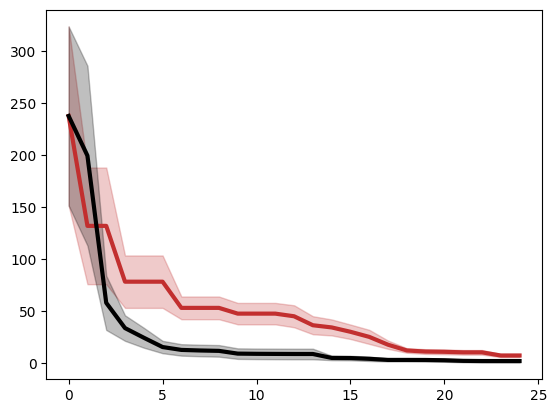

In [40]:
N = 20
total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')


N = 20
total_record = np.array(Warped_BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

# Save

In [41]:
np.savetxt('Rosenbrock2D_BO_EI', BO_EI, delimiter=',')

In [42]:
np.savetxt('Rosenbrock2D_Warped_BO_EI', Warped_BO_EI, delimiter=',')

In [17]:
np.savetxt('Branin2D_Warped_BO_TEI', Warped_BO_TEI, delimiter=',')

In [17]:
np.savetxt('Hartmann3d_Warped_BO_TEI2', Warped_BO_TEI2, delimiter=',')

# plots

In [2]:
import os

Text(0.5, 1.0, 'Ackley 2D')

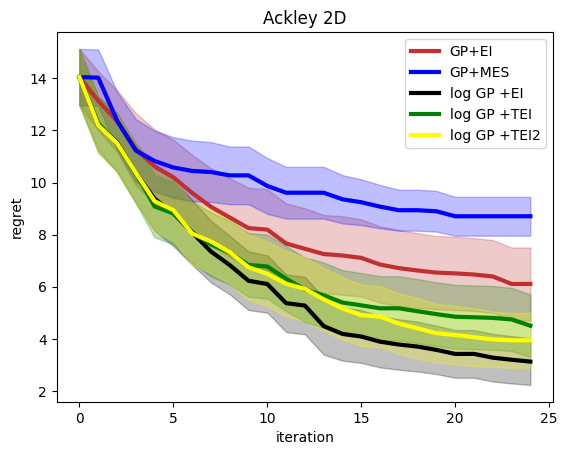

In [23]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Ackley2D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Ackley2D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Ackley2D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Ackley2D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Ackley2D_Warped_BO_TEI2'), delimiter=',')

fstar = 0.

N = 20
total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

N = 20
total_record = np.array(Warped_BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.array(Warped_BO_TEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record =np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Ackley 2D')

Text(0.5, 1.0, 'Beale 2D')

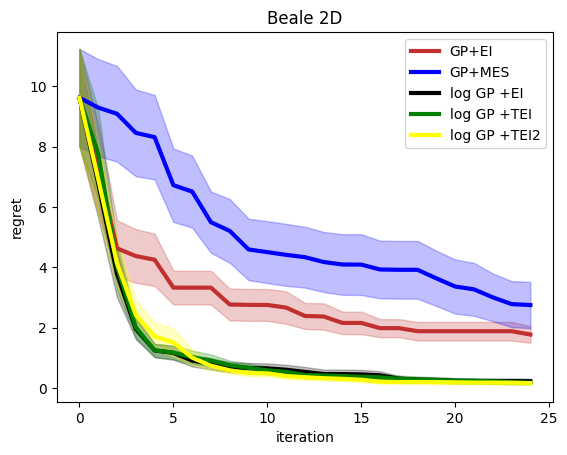

In [13]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Beale2D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Beale2D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Beale2D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Beale2D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Beale2D_Warped_BO_TEI2'), delimiter=',')

fstar = 0.

N = 20
total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


N = 20
total_record = np.array(Warped_BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.array(Warped_BO_TEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record =np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Beale 2D')

Text(0.5, 1.0, 'Levy 2D')

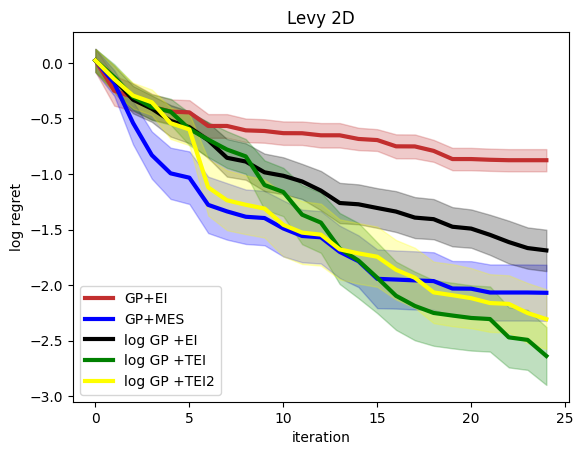

In [29]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Levy2D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Levy2D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Levy2D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Levy2D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Levy2D_Warped_BO_TEI2'), delimiter=',')

fstar = 0.

N = 20
total_record = np.log10(np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record = np.log10(np.array(BO_MES)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

N = 20
total_record = np.log10(np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.log10(np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record = np.log10(np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.xlabel('iteration')
plt.ylabel('log regret')


plt.legend()
plt.title('Levy 2D')

Text(0.5, 1.0, 'Branin 2D')

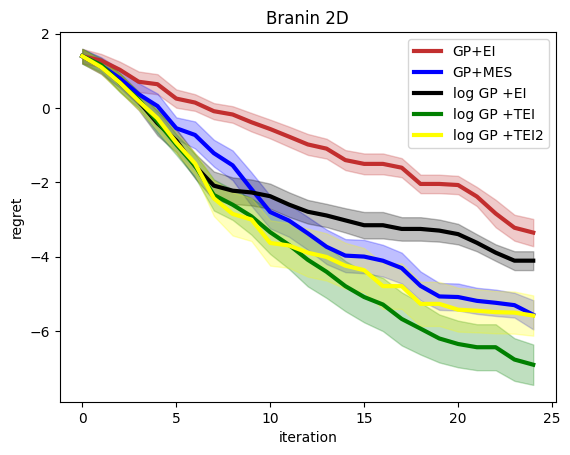

In [18]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Branin2D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Branin2D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Branin2D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Branin2D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Branin2D_Warped_BO_TEI2'), delimiter=',')

fstar = 0.397887

N = 20
total_record = np.log(np.array(BO_EI)-fstar)    #np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record = np.log(np.array(BO_MES)-fstar)       #np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

N = 20
total_record = np.log(np.array(Warped_BO_EI)-fstar)       #np.array(Warped_BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.log(np.array(Warped_BO_TEI)-fstar) #np.array(Warped_BO_TEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record =np.log(np.array(Warped_BO_TEI2)-fstar) #np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')


plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Branin 2D')

Text(0.5, 1.0, 'Rosenbrock 2D')

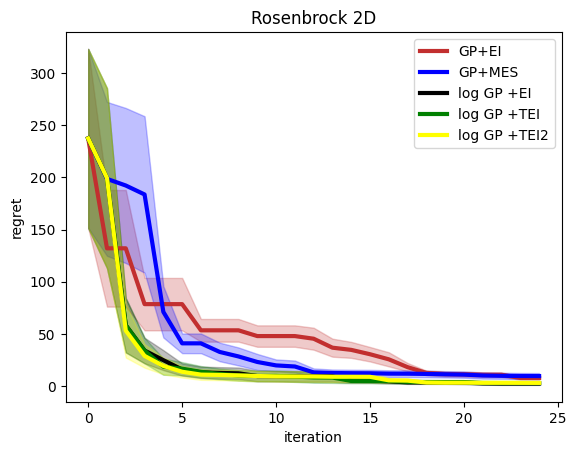

In [18]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Rosenbrock2D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Rosenbrock2D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Rosenbrock2D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Rosenbrock2D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Rosenbrock2D_Warped_BO_TEI2'), delimiter=',')

fstar = 0.

N = 20
total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

N = 20
total_record = np.array(Warped_BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.array(Warped_BO_TEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record =np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Rosenbrock 2D')

Text(0, 0.5, 'log regret')

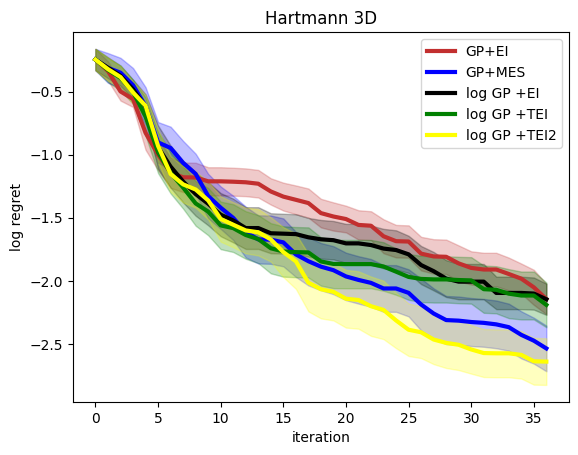

In [20]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Hartmann3D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'Hartmann3D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'Hartmann3D_Warped_BO_EI'), delimiter=',')
Warped_BO_TEI = np.genfromtxt(os.path.join(os.getcwd(),'Hartmann3D_Warped_BO_TEI'), delimiter=',')
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'Hartmann3d_Warped_BO_TEI2'), delimiter=',')

fstar = -3.86278

N = 20
total_record = np.log10(np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

N = 20
total_record =  np.log10(np.array(BO_MES)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


N = 20
total_record =  np.log10(np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

N = 20
total_record = np.log10(np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

N = 20
total_record =np.log10(np.array(Warped_BO_TEI2)-fstar) #np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')


plt.legend()
plt.title('Hartmann 3D')

plt.xlabel('iteration')
plt.ylabel('log regret')